# **Sentiment Analysis on Reddit**

This program takes a subreddit, a file containing topics, and a few parameters to generate a list of topics found in posts on the subreddit and gives numerical values about the sentiment of the given topic.

In [17]:
# Subreddit to perform sentiment analysis on:
subreddit = 'pcgaming'
# Name of file that contains the topics to search the subreddit for.
topic_file = 'topic_list.csv'
# Number of posts to check for topics in.
num_posts = 100
# Maximum number of comments to analyze from each post.
max_comments = 50

## **0. Imports**

In [18]:
import praw
import pandas as pd
import numpy as np
import nltk
from fuzzywuzzy import process, fuzz
import statistics
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

import bot1

## **1. Finding Topics**

In [19]:
def get_topic_fuzzy(post_text, topic_df):
    topic = ''
    for t in topic_df['Topic']:
        t = str(t)
        t_split = t.split()
        topic_len = len(t_split)
        post_list = post_text.split()
        ngram = nltk.ngrams(post_list, topic_len)
        for grams in ngram:
            r_list = [0] * len(grams)
            for i, word in enumerate(t_split):
                r_list[i] = fuzz.ratio(word, grams[i])
            if statistics.mean(r_list) >= 90:
                return ' '.join(t_split)
    return topic

def get_topic_first(post_text, topic_df):
    topic = ''
    for t in topic_df['Topic']:
        t = str(t)
        t_split = t.split()
        topic_len = len(t_split)
        post_list = post_text.split()
        ngram = nltk.ngrams(post_list, topic_len)
        for grams in ngram:
            print(grams)
            exit()
    return topic

def get_topic_exact(post_text, topic_df):
    topic = ''
    for t in topic_df['Topic']:
        t = str(t)
        t_split = t.split()
        topic_len = len(t_split)
        post_list = post_text.split()
        ngram = nltk.ngrams(post_list, topic_len)
        for grams in ngram:
            if list(grams) == t_split:
                return ' '.join(t_split)
    return topic

def get_url(postID):
    return 'reddit.com/r/' + subreddit + '/comments/' + postID

reddit = praw.Reddit(client_id=bot1.app_id, client_secret=bot1.app_secret, user_agent=bot1.app_ua)
sub = reddit.subreddit(subreddit)
topic_df = pd.read_csv(topic_file)
posts = pd.DataFrame(columns=['PostID', 'Title', 'Topic'])

for post in sub.hot(limit=num_posts):
    url = get_url(post.id)
    title = post.title
    #topic = get_topic_fuzzy(title, topic_df)
    #topic = get_topic_first(title, topic_df)
    topic = get_topic_exact(title, topic_df)
    if topic != '':
        posts.loc[len(posts.index)] = [post.id, title, topic]

posts

,PostID,Title,Topic
0,x14kax,Terraria is now the first game on Steam with o...,Terraria
1,x1lxmi,Scorn will also be available on GOG with DRM-f...,Scorn
2,x1oa9z,Teenage Mutant Ninja Turtles: The Cowabunga Co...,Teenage Mutant Ninja Turtles: The Cowabunga Co...
3,x1kg1v,Pathfinder: Wrath of the Righteous – The Treas...,Pathfinder: Wrath of the Righteous
4,x1cii6,Mojang says it's learned from showing off Mine...,Minecraft
5,x1jy0e,Victoria 3 Live Stream + Release Date Announce...,Victoria 3
6,x1meev,Victoria 3 Hands-On: Aiming to Make Grand Stra...,Victoria 3
7,x1ko5y,Commandos 3 - HD Remaster has released on Steam,Commandos 3 - HD Remaster
8,x1iljs,Playdead' (Inside/Limbo) next game is confirme...,Unreal
9,x1lm0w,The Callisto Protocol Has an Achievement for S...,The Callisto Protocol


## **2. Sentiment Analysis on Comments**

In [20]:
def get_comments(ID):
    post = reddit.submission(id=ID)
    all_comments = []
    post.comments.replace_more(limit=None)
    for index, comments in enumerate(post.comments.list()):
        if index >= max_comments:
            break
        all_comments.append(comments.body)
        #all_comments.append(nltk.tokenize.sent_tokenize(comments.body))
    return pd.DataFrame(all_comments, columns=['Comment'])
    
def preprocess_comment(df):
    df['Comment'] = df['Comment'].str.lower()
    df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
    df['Comment'] = df['Comment'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    df['Tokenized_Comment'] = df['Comment'].apply(nltk.tokenize.word_tokenize)
    stopwords = set(nltk.corpus.stopwords.words('english'))
    df['Tokenized_Comment'] = df['Tokenized_Comment'].apply(lambda x: [item for item in x if item not in stopwords])
    stemmer = nltk.stem.PorterStemmer()
    df['Tokenized_Comment'] = df['Tokenized_Comment'].apply(lambda x: [stemmer.stem(y) for y in x])
    return df

def score_comments(ID):
    comments_df = get_comments(ID)
    #comments_df = preprocess_comment(comments_df)
    sia = SentimentIntensityAnalyzer()
    results = []
    for index, row in comments_df.iterrows():
        pol_score = sia.polarity_scores(row['Comment'])
        comments_df.loc[index,'pos'] = pol_score['pos']
        comments_df.loc[index,'neu'] = pol_score['neu']
        comments_df.loc[index,'neg'] = pol_score['neg']
        comments_df.loc[index,'compound'] = pol_score['compound']
    out_values = []
    out_values.append(comments_df['pos'].mean())
    out_values.append(comments_df['neu'].mean())
    out_values.append(comments_df['neg'].mean())
    out_values.append(comments_df['compound'].mean())
    out_values.append(len(comments_df.index))
    return out_values

for post in sub.hot(limit=num_posts):
    if posts['PostID'].str.contains(post.id).any():
        out_values = score_comments(post.id)
        index = posts.index[posts['PostID'] == post.id].tolist()
        posts.loc[index,'Avg_Pos'] = out_values[0]
        posts.loc[index,'Avg_Neu'] = out_values[1]
        posts.loc[index,'Avg_Neg'] = out_values[2]
        posts.loc[index,'Avg_Compound'] = out_values[3]
        posts.loc[index,'Num_Comments'] = out_values[4]

posts['Num_Comments'] = posts['Num_Comments'].astype('int64')
posts = posts.sort_values(by=['Avg_Compound'], ascending=False)
posts

,PostID,Title,Topic,Avg_Pos,Avg_Neu,Avg_Neg,Avg_Compound,Num_Comments
14,x1m1sz,"High on Life is actually funny, and is funnies...",High on Life,0.321750,0.619000,0.059000,0.613850,4
12,x0qevi,Nobody Saves the World is coming to GOG,Nobody Saves the World,0.208833,0.755667,0.035667,0.397183,12
0,x14kax,Terraria is now the first game on Steam with o...,Terraria,0.217680,0.726120,0.056180,0.370194,50
13,x0dh4q,"[Rumor] According to SteamDB, Dwarf Fortress i...",Dwarf Fortress,0.170186,0.801953,0.027860,0.341007,43
20,wz3p6m,Voxel Doom Tested: id Software Classic Gets A ...,Doom,0.186536,0.757536,0.055964,0.306068,28
15,wzv1a7,Inside Marvel's Spider-Man Remastered on PC - ...,Marvel's Spider-Man Remastered,0.103020,0.840420,0.056540,0.269906,50
6,x1meev,Victoria 3 Hands-On: Aiming to Make Grand Stra...,Victoria 3,0.142000,0.756300,0.101700,0.242490,10
3,x1kg1v,Pathfinder: Wrath of the Righteous – The Treas...,Pathfinder: Wrath of the Righteous,0.106600,0.842867,0.050533,0.203673,15
2,x1oa9z,Teenage Mutant Ninja Turtles: The Cowabunga Co...,Teenage Mutant Ninja Turtles: The Cowabunga Co...,0.132615,0.808538,0.058846,0.198192,13
5,x1jy0e,Victoria 3 Live Stream + Release Date Announce...,Victoria 3,0.132235,0.796353,0.071412,0.195400,17


## **3. Output Topic-Sentiment Values**

In [21]:
topic_sentiments = pd.DataFrame(columns=['Topic', 'Avg_Pos', 'Avg_Neu', 'Avg_Neg', 'Avg_Compound', 'Num_Comments'])
for index, row in posts.iterrows():
    if topic_sentiments['Topic'].str.contains(row['Topic']).any():
        new_index = topic_sentiments.index[topic_sentiments['Topic'] == row['Topic']]
        topic_sentiments.loc[new_index,'Avg_Pos'] = (row['Avg_Pos'] + topic_sentiments.iloc[new_index]['Avg_Pos']) / 2
        topic_sentiments.loc[new_index,'Avg_Neu'] = (row['Avg_Neu'] + topic_sentiments.iloc[new_index]['Avg_Neu']) / 2
        topic_sentiments.loc[new_index,'Avg_Neg'] = (row['Avg_Neg'] + topic_sentiments.iloc[new_index]['Avg_Neg']) / 2
        topic_sentiments.loc[new_index,'Avg_Compound'] = (row['Avg_Compound'] + topic_sentiments.iloc[new_index]['Avg_Compound']) / 2
        topic_sentiments.loc[new_index,'Num_Comments'] = row['Num_Comments'] + topic_sentiments.iloc[new_index]['Num_Comments']
    else:
        topic_sentiments.loc[len(topic_sentiments.index)] = [row['Topic'], row['Avg_Pos'], row['Avg_Neu'], row['Avg_Neg'], row['Avg_Compound'], row['Num_Comments']] 

topic_sentiments

,Topic,Avg_Pos,Avg_Neu,Avg_Neg,Avg_Compound,Num_Comments
0,High on Life,0.321750,0.619000,0.059000,0.613850,4
1,Nobody Saves the World,0.208833,0.755667,0.035667,0.397183,12
2,Terraria,0.217680,0.726120,0.056180,0.370194,50
3,Dwarf Fortress,0.170186,0.801953,0.027860,0.341007,43
4,Doom,0.186536,0.757536,0.055964,0.306068,28
5,Marvel's Spider-Man Remastered,0.103020,0.840420,0.056540,0.269906,50
6,Victoria 3,0.137118,0.776326,0.086556,0.218945,27
7,Pathfinder: Wrath of the Righteous,0.106600,0.842867,0.050533,0.203673,15
8,Teenage Mutant Ninja Turtles: The Cowabunga Co...,0.132615,0.808538,0.058846,0.198192,13
9,Cult of the Lamb,0.133200,0.773513,0.093300,0.100996,48


## **4. Distribution of Sentiment Scores**

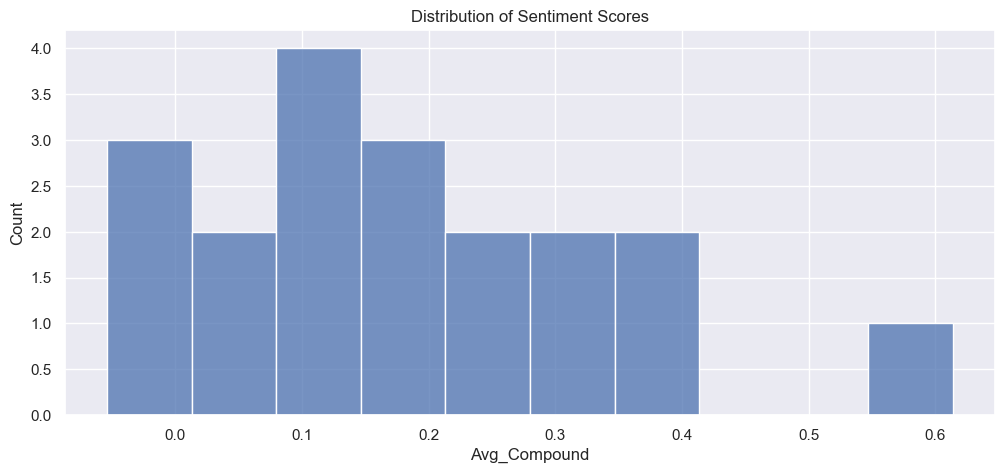

In [22]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12,5))
plt.title('Distribution of Sentiment Scores')
sns.histplot(x='Avg_Compound', data=topic_sentiments, bins=10)
plt.show()